**Experiment - 10**

**Solving a MarkovDecision Process (MDP)**
This assignment is your first step into Reinforcement Learning. We will focus on the
"planning" problem, where we have a perfect model of the environment (the MDP) and want
to find the best possible plan (the optimal policy) before the agent even takes a step.
You will be implementing Value Iteration, a classic algorithm that repeatedly applies the
Bellman equation to find the true "value" of being in every state.1 Once we know the value of
all states, figuring out the best action is easy: just move to the state with the highest value!

Experiment 10 : Solving a Markov Decision Process (MDP) 1

You will solve the "GridWorld" problem, a 3x4 grid with a goal, a "pit" (danger), and walls.
Your agent must learn the shortest, safest path to the goal.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

**Task 1: Define the GridWorld (The MDP) (30 Marks)**

First, we must define the "rules of the game." You will not use any existing RL libraries (like
gym ).
You will define the world yourself.

The world is a 3x4 grid:

States (S): The grid cells. (0,0) , (0,1) , (0,2) , (0,3) , etc.
Walls: There is a wall at (1,1) .

The agent cannot move into this state.

Terminal States:
Goal: (0,3) (e.g., a gem)
Pit: (1,3) (e.g., a fire pit)
Actions (A): The agent can try to move ['up', 'down', 'left', 'right'] .

1. Define States: Create a list or set of all valid states (all (row, col) tuples, except the wall
at (1,1) ).

2. Define Rewards (R): Create a dictionary or function that defines the reward R(s) for
being in a state s .
Goal (0,3) : +1
Pit (1,3) : 1
All other states: 0.04 (This is a "living penalty" to encourage the agent to find the
shortest path).
3. Define Discount Factor: Use gamma = 0.99 .
4. Define Transition Model (T): This is the most important part. You must create a
function that defines the probabilities of moving. The world is stochastic
(unpredictable).


If the agent chooses an action (e.g., 'up' ):
80% chance it goes in the intended direction (e.g., 'up' ).

10% chance it slips and goes 90 degrees to the left (e.g., 'left' ).

10% chance it slips and goes 90 degrees to the right (e.g., 'right' ).

Handling Walls/Boundaries: If a move (intended or slipped) would land the agent
in a wall (like (1,1) ) or off the grid, the agent stays in its current state.


Terminal States: Once the agent enters a terminal state (Goal or Pit), it stays there
and receives no further rewards.

(For Value Iteration, we can simplify this: terminal
states have a value of 0 and no actions leading out).

To Implement: Create a helper function get_next_states(s, a) that, given a state s and action
a, returns a list of (probability, next_state) tuples.

For example, from (0,0):
get_next_states((0,0), 'right') might return:
[(0.8, (0,1)), (0.1, (0,0)), (0.1, (1,0))]
(0.8 for 'right', 0.1 for 'up' (slips left, hits wall, stays at (0,0)), 0.1 for 'down' (slips right)).

In [ ]:
# Cell 2: Define GridWorld (MDP)

GRID_H, GRID_W = 3, 4                # 3x4 grid
WALL = (1, 1)                         # blocked cell
GOAL = (0, 3)                         # terminal +1
PIT  = (1, 3)                         # terminal -1

ACTIONS = ["up", "down", "left", "right"]
DIRS = {
    "up":    (-1,  0),
    "down":  ( 1,  0),
    "left":  ( 0, -1),
    "right": ( 0,  1)
}

# For slip dynamics (left/right turn relative to intended)
LEFT_OF  = {"up":"left", "left":"down", "down":"right", "right":"up"}
RIGHT_OF = {"up":"right","right":"down","down":"left","left":"up"}

def in_bounds(s):
    r, c = s
    return 0 <= r < GRID_H and 0 <= c < GRID_W

def is_wall(s):
    return s == WALL

def is_terminal(s):
    return s in (GOAL, PIT)

def states_list():
    S = []
    for r in range(GRID_H):
        for c in range(GRID_W):
            if (r, c) != WALL:
                S.append((r, c))
    return S

def step_from(s, a):
    """Deterministic move for action a; if hits wall/boundary, stay."""
    if is_terminal(s):       # terminals are absorbing
        return s
    dr, dc = DIRS[a]
    ns = (s[0] + dr, s[1] + dc)
    if not in_bounds(ns) or is_wall(ns):
        return s
    return ns

def get_next_states(s, a, p_intended=0.8, p_left=0.1, p_right=0.1):
    """Return [(prob, next_state), ...] given s and chosen action a."""
    if is_terminal(s):
        return [(1.0, s)]
    a_left  = LEFT_OF[a]
    a_right = RIGHT_OF[a]
    outcomes = [
        (p_intended, step_from(s, a)),
        (p_left,     step_from(s, a_left)),
        (p_right,    step_from(s, a_right)),
    ]
    # merge same next states (could be duplicates if bumps to wall/border)
    agg = {}
    for p, ns in outcomes:
        agg[ns] = agg.get(ns, 0) + p
    return [(p, ns) for ns, p in agg.items()]

def make_reward(living_penalty=-0.04):
    """Per-state reward for arriving in/being at a state (standard gridworld)."""
    R = {}
    for s in states_list():
        if s == GOAL:
            R[s] = 1.0
        elif s == PIT:
            R[s] = -1.0
        else:
            R[s] = living_penalty
    return R

**Task 2: Value Iteration Algorithm (From Scratch) (40 Marks)**

Now you will implement the algorithm to solve the MDP.
1. Initialize Value Function: Create your main data structure, V , which will be a
dictionary or a 2D NumPy array. V[s] stores the current estimated value of being in state
s . Initialize the value of all states to 0.0.
2. Implement Value Iteration:
You will loop until the V function converges.
Convergence is when the maximum change in V for any state in a single iteration is
very small.
Use a threshold theta = 0.0001 .
3. Run: Run your value_iteration function. It should return the final, converged V table.

In [ ]:
# Cell 3: Value Iteration
def q_value(s, a, V, R, gamma):
    """Q(s,a) = sum_p [ p * ( R(ns) + gamma * V[ns] ) ]"""
    return sum(p * (R[ns] + gamma * V[ns]) for p, ns in get_next_states(s, a))

def value_iteration(gamma=0.99, theta=1e-4, living_penalty=-0.04, verbose=False):
    S = states_list()
    R = make_reward(living_penalty)
    V = {s: 0.0 for s in S}

    # Terminals often set to 0 for post-entry value; their immediate rewards are in R
    V[GOAL] = 0.0
    V[PIT]  = 0.0

    while True:
        delta = 0.0
        for s in S:
            if is_terminal(s):
                continue
            q_vals = [q_value(s, a, V, R, gamma) for a in ACTIONS]
            v_new = max(q_vals)
            delta = max(delta, abs(v_new - V[s]))
            V[s] = v_new
        if verbose:
            print(f"delta = {delta:.6f}")
        if delta < theta:
            break
    return V, R

**Task 3: Policy Extraction (From Scratch) (15 Marks)**

The V table tells you how good each state is, but not what to do. Now, you must extract the
optimal policy ( Pi ) from V .
1. Create Policy Table: Create a new table Pi (dictionary or 2D array) to store the best
action for each state.

Experiment 10 : Solving a Markov Decision Process (MDP) 3

2. One-Step Lookahead: For each state s :
Calculate the expected value ( Q(s,a) ) for all four actions, just like you did in Task 2.
Find the action a that gives the maximum Q(s,a) value.
Store this best action (e.g., 'up' ) in Pi[s] .
3. Return: Return the final Pi table. This Pi is the optimal policy!

In [ ]:
# Cell 4: Extract optimal policy from V
ARROWS = {"up":"^", "down":"v", "left":"<", "right":">"}

def extract_policy(V, R, gamma=0.99):
    Pi = {}
    for s in states_list():
        if s == GOAL:
            Pi[s] = "G"
        elif s == PIT:
            Pi[s] = "X"
        elif s == WALL:
            continue
        else:
            qs = {a: q_value(s, a, V, R, gamma) for a in ACTIONS}
            best_a = max(qs, key=qs.get)
            Pi[s] = best_a
    return Pi

**Task 4: Visualization and Analysis (15 Marks)**

1. Visualize Value Function: Write a simple function to print your V table in a 3x4 grid
format. Use seaborn.heatmap for a much better visualization.
2. Visualize Policy: Write a simple function to print your Pi table in a 3x4 grid, using
arrows ( ^ , v , < , > ) to represent the actions.
3. Analyze:
Question 1: Run your full pipeline. Print the final V table and the final Pi table.
Does the policy make sense? Does it correctly avoid the pit and find the goal?
Question 2: Change the "living penalty" R(s) from 0.04 to 0.0 . Rerun. Does the
policy change? Why or why not?
Question 3: Change the "living penalty" R(s) from 0.04 to 0.5 (a high penalty).
Rerun. What happens to the policy? Does the agent take a different path? Why?

In [ ]:
# Cell 5: Helpers to view V and Pi

def value_grid(V):
    """Return a 2D array shaped (H, W) with np.nan for the wall."""
    grid = np.full((GRID_H, GRID_W), np.nan)
    for s, v in V.items():
        r, c = s
        grid[r, c] = v
    grid[WALL] = np.nan
    return grid

def policy_grid(Pi):
    """Return a 2D array of strings for arrows/G/X/empty."""
    grid = np.full((GRID_H, GRID_W), "", dtype=object)
    for r in range(GRID_H):
        for c in range(GRID_W):
            s = (r, c)
            if s == WALL:
                grid[r, c] = "█"
            elif s == GOAL:
                grid[r, c] = "G"
            elif s == PIT:
                grid[r, c] = "X"
            else:
                a = Pi.get(s, None)
                grid[r, c] = ARROWS[a] if a in ARROWS else "?"
    return grid

def show_value_heatmap(V, title="Value Function"):
    data = value_grid(V)
    plt.figure(figsize=(5, 3.2))
    ax = sns.heatmap(data, annot=True, fmt=".2f", cbar=True, linewidths=.5)
    ax.set_title(title)
    ax.invert_yaxis()  # so (0,0) is top-left
    plt.show()

def print_policy(Pi, title="Policy (arrows)"):
    print(title)
    grid = policy_grid(Pi)
    for r in range(GRID_H):
        row = "  ".join(grid[r, :])
        print(row)

Final Value Table (numbers):
[[0.824 0.893 0.955 0.   ]
 [0.764   nan 0.688 0.   ]
 [0.698 0.639 0.606 0.382]]


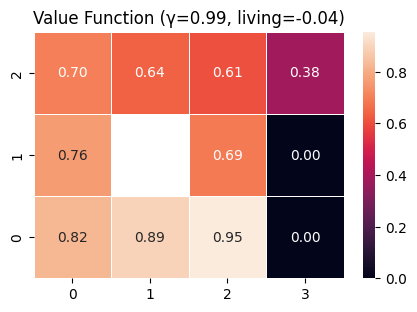

Optimal Policy (G=goal, X=pit, █=wall)
>  >  >  G
^  █  ^  X
^  <  ^  <


In [ ]:
# Cell 6: Run once with default gamma and living penalty
GAMMA = 0.99
THETA = 1e-4
LIVING = -0.04  # default

V, R = value_iteration(gamma=GAMMA, theta=THETA, living_penalty=LIVING)
Pi = extract_policy(V, R, gamma=GAMMA)

print("Final Value Table (numbers):")
print(value_grid(V))
show_value_heatmap(V, title=f"Value Function (γ={GAMMA}, living={LIVING})")
print_policy(Pi, title="Optimal Policy (G=goal, X=pit, █=wall)")

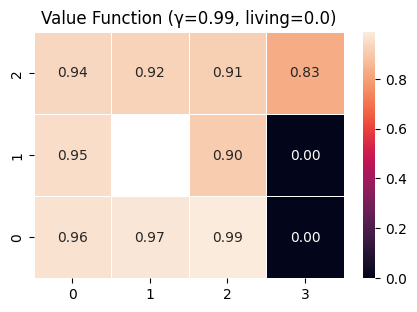

Optimal Policy with living penalty = 0.0
>  >  >  G
^  █  <  X
^  <  <  v


In [ ]:
# Cell 7: living penalty = 0.0
LIVING2 = 0.0
V2, R2 = value_iteration(gamma=GAMMA, theta=THETA, living_penalty=LIVING2)
Pi2 = extract_policy(V2, R2, gamma=GAMMA)

show_value_heatmap(V2, title=f"Value Function (γ={GAMMA}, living={LIVING2})")
print_policy(Pi2, title="Optimal Policy with living penalty = 0.0")

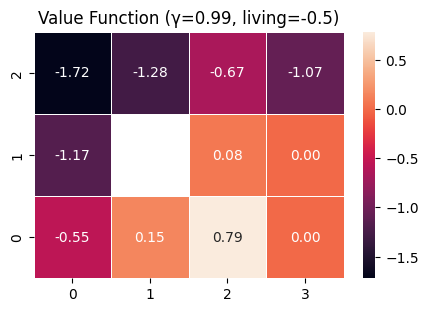

Optimal Policy with living penalty = -0.5
>  >  >  G
^  █  ^  X
^  >  ^  ^


In [ ]:
# Cell 8: living penalty = -0.5 (high penalty)
LIVING3 = -0.5
V3, R3 = value_iteration(gamma=GAMMA, theta=THETA, living_penalty=LIVING3)
Pi3 = extract_policy(V3, R3, gamma=GAMMA)

show_value_heatmap(V3, title=f"Value Function (γ={GAMMA}, living={LIVING3})")
print_policy(Pi3, title="Optimal Policy with living penalty = -0.5")

In [ ]:
# Cell 9: Compare policies side-by-side
def policy_as_lines(Pi):
    grid = policy_grid(Pi)
    return ["  ".join(grid[r, :]) for r in range(GRID_H)]

lines1 = policy_as_lines(Pi)
lines2 = policy_as_lines(Pi2)
lines3 = policy_as_lines(Pi3)

print("Baseline (living=-0.04)      | living=0.0                 | living=-0.5")
for r in range(GRID_H):
    print(f"{lines1[r]:28s} | {lines2[r]:25s} | {lines3[r]}")

Baseline (living=-0.04)      | living=0.0                 | living=-0.5
>  >  >  G                   | >  >  >  G                | >  >  >  G
^  █  ^  X                   | ^  █  <  X                | ^  █  ^  X
^  <  ^  <                   | ^  <  <  v                | ^  >  ^  ^
